In [14]:
import os, csv
import pandas as pd
from prophet import Prophet
import datetime
import matplotlib.pyplot as plt
from prophet.plot import plot_plotly, plot_components_plotly
import random

# Change these parameters to enable or disable data processing components
SQUASHER_ENABLED=True
AUGMENTER_ENABLED=True
RANDOM_NOISE_INJECTER=True

# Change those parameters to choose the csv file
# Choose the demo folder between "sample_waveforms_demo" and "real_traffic"
DEMO_FOLDER="real_traffic"
# Choose the file from that folder (without the .csv extension)
INPUT_CSV_FILE="h1"

DT=0.4 # See the explanation below for DT
TIME_AUGMENTER_MULTIPLIER=20000 # For a second of delta time in the input file, this becomes TIME_AUGMENTER_MULTIPLIER seconds in the output file
AUGMENTER_MULTIPLIER=1 # How many times repeat the input (used usually in the waveform examples)
RANDOM_NOISE_N_PACKETS=2 # Maximum value (in number of packets) of random noise to be added or subtracted

'''
From the following timestamps as inputs

0.00
0.03
0.04
0.04
0.04
0.1
0.15
0.25
0.39

with DT=0.1, the output becomes

0.00, 5
0.10, 2
0.20, 1
0.30, 1
'''

'\nFrom the following timestamps as inputs\n\n0.00\n0.03\n0.04\n0.04\n0.04\n0.1\n0.15\n0.25\n0.39\n\nwith DT=0.1, the output becomes\n\n0.00, 5\n0.10, 2\n0.20, 1\n0.30, 1\n'

The Python function `dump_to_csv`creates a CSV file to store data from two lists: tss (timestamps) and npacks (packet counts).  
It constructs a file path using **WIRESHARK_INPUT_FOLDER** and the provided output_filename.   
It then writes a header row and iterates through tss, formatting timestamps and writing them with corresponding packet counts to the CSV file.

In [15]:
WIRESHARK_INPUT_FOLDER="prophet-data"

def dump_to_csv(output_filename: str, tss: list, npacks: list):
    output_data_file = os.path.join(WIRESHARK_INPUT_FOLDER, output_filename)
    with open(output_data_file, "w+") as output_file:
        output_file.write("ds,y\r\n")
        for idx in range(0, len(tss) - 1):
            output_file.write(datetime.datetime.strftime(tss[idx], "%Y-%m-%d %H:%M:%S.%f") + "," + str(npacks[idx]) +"\r\n")
        output_file.close()

The code reads timestamps from a CSV (assuming second column) and converts them to `datetime` objects relative to current time, storing them in a list. It defines a function `to_ts_f` to handle the conversion.

In [16]:
raw_data = []
timestamps = []
raw_input_file_path = os.path.join(WIRESHARK_INPUT_FOLDER, DEMO_FOLDER, INPUT_CSV_FILE + ".csv")
now = datetime.datetime.now()

def to_ts_f(x):
    return now + datetime.timedelta(seconds=float(x))

with open(raw_input_file_path) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            timestamps.append(to_ts_f(row[1]))


Column names are 1, 0.000000


The code defines functions to process timestamps and weights. `squash_timestamps_weighted` groups timestamps within a threshold and assigns a weight to each group. 
If enabled by `SQUASHER_ENABLED`, it creates new timestamps based on the original ones and weight information.


In [17]:
def squash_timestamps_weighted(ts: list, W: list, dt: float) -> list:
    L = len(ts)
    assert (L == len(W))
    weighted = []
    pts = datetime.datetime.fromtimestamp(0)
    tmp = 0
    for idx in range(0, L - 1):
        cts = ts[idx]
        if (cts - pts).total_seconds() > dt:
            weighted.append(tmp)
            tmp = W[idx]
            pts = cts
        else:
            tmp += W[idx]
    return weighted

if SQUASHER_ENABLED:
    nW = squash_timestamps_weighted(timestamps, [1] * len(timestamps), DT)
    L = len(nW)
    bts = timestamps[0]
    nts = []
    for idx in range(0, L - 1):
        nts.append(bts + datetime.timedelta(seconds=(idx * DT * TIME_AUGMENTER_MULTIPLIER)))
    npackets = nW
    timestamps = nts

The provided code implements data augmentation (if enabled). It creates additional datasets by shifting the original timestamps along the timeline and replicates the corresponding packet counts. This technique increases the training data size and introduces variations in the temporal distribution, potentially improving model robustness.

In [18]:
augmented_timestamps = []
augmented_npackets = []

if AUGMENTER_ENABLED:
    L = len(timestamps)
    time_delta = timestamps[L-1] - timestamps[0]
    for i in range(0, AUGMENTER_MULTIPLIER):
        for idx in range(0, L - 1):
            new_ts = (timestamps[idx] + (time_delta * i))
            augmented_timestamps.append(new_ts)
            augmented_npackets.append(npackets[idx])

In [19]:
if RANDOM_NOISE_INJECTER == True:
    for idx in range(0, len(augmented_npackets) - 1):
        augmented_npackets[idx] += ((random.random() - 0.5) * RANDOM_NOISE_N_PACKETS)

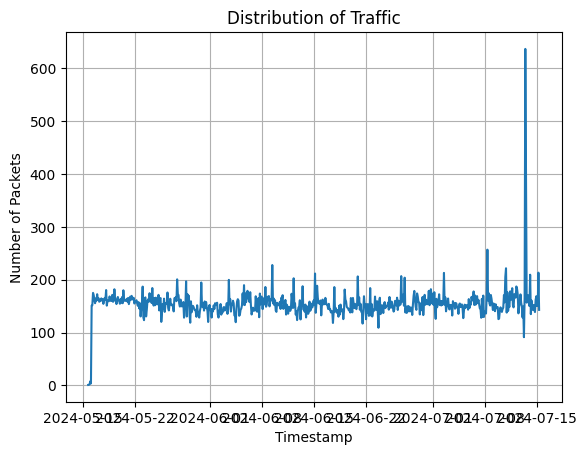

In [20]:
def plot_ts4prophet(x_values, y_values):
    plt.plot(x_values, y_values) 
    plt.xlabel('Timestamp')
    plt.ylabel('Number of Packets')
    plt.title('Distribution of Traffic')
    plt.grid(True)
    plt.show()
    
plot_ts4prophet(augmented_timestamps, augmented_npackets)

In [21]:
output_data_file = os.path.join(WIRESHARK_INPUT_FOLDER, DEMO_FOLDER, INPUT_CSV_FILE + "_prophet_input.csv")
with open(output_data_file, "w+") as output_file:
    output_file.write("ds,y\r\n")
    for idx in range(0, len(timestamps) - 1):
        output_file.write(datetime.datetime.strftime(augmented_timestamps[idx], "%Y-%m-%d %H:%M:%S") + "," + str(augmented_npackets[idx]) + "\r\n")
    output_file.close()

In [22]:
df = pd.read_csv(output_data_file)
m = Prophet(changepoint_prior_scale=0.01).fit(df)

16:08:45 - cmdstanpy - INFO - Chain [1] start processing
16:08:45 - cmdstanpy - INFO - Chain [1] done processing


/home/gmazzucchi/.local/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/gmazzucchi/.local/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



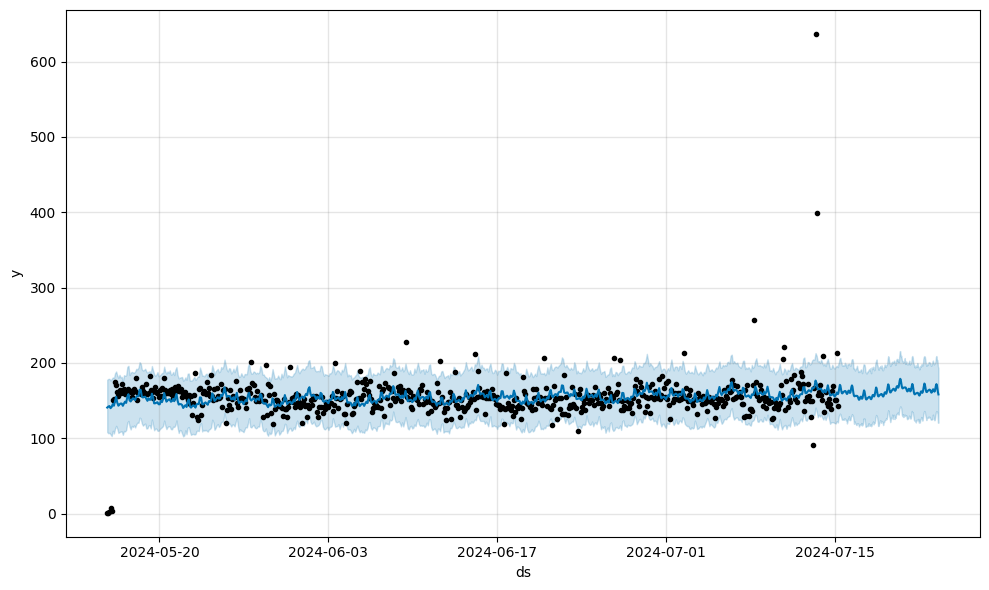

In [23]:
future = m.make_future_dataframe(periods=200, freq='h')
fcst = m.predict(future)
fig = m.plot(fcst)

In [24]:
plot_plotly(m, fcst)

In [25]:
plot_components_plotly(m, fcst)